In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zomato-reviews-ratings/zomato_reviews.csv


**IMPORT LIBRARIES:**

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import emoji
from PIL import Image
import requests
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

!pip install transformers
!pip install simpletransformers
import torch
import logging
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
#plt.style.use("plotly_dark")

import re
from textblob import TextBlob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=d859ae823d0f80e7be2834633934c96b1837175641e43f7ec8939348af1dfeee
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


2024-07-24 05:50:20.736633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 05:50:20.736741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 05:50:20.886508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**EDA (Exploratory Data Analysis):**

In [3]:
#reading our dataset 

df = pd.read_csv('/kaggle/input/zomato-reviews-ratings/zomato_reviews.csv')
df.head()

,Unnamed: 0,rating,review
0,0,5,nice
1,1,5,"best biryani , so supportive staff of outlet ,..."
2,2,4,delivery boy was very decent and supportive.👌👍
3,3,1,"worst biryani i have tasted in my life, half o..."
4,4,5,all food is good and tasty . will order again ...


In [4]:
#dropping first column as it is not of any use 

df.drop(df.columns[0], axis=1, inplace=True)
print(df.head())

   rating                                             review
0       5                                               nice
1       5  best biryani , so supportive staff of outlet ,...
2       4     delivery boy was very decent and supportive.👌👍
3       1  worst biryani i have tasted in my life, half o...
4       5  all food is good and tasty . will order again ...


In [5]:
df.shape    #shape of dataset

(5479, 2)

In [6]:
df.describe()    #basic stats

,rating
count,5479.000
mean,3.161
std,1.782
min,1.000
25%,1.000
50%,4.000
75%,5.000
max,5.000


In [7]:
df.describe     

<bound method NDFrame.describe of       rating                                             review
0          5                                               nice
1          5  best biryani , so supportive staff of outlet ,...
2          4     delivery boy was very decent and supportive.👌👍
3          1  worst biryani i have tasted in my life, half o...
4          5  all food is good and tasty . will order again ...
...      ...                                                ...
5474       5                                           complain
5475       5  it took 1 hour to assign valvet and thn prepar...
5476       5  took for an hour to prepare 3 khawsa, which in...
5477       1  very very late, littrally did time pass and it...
5478       1  Taste was stale and they give only 5 pieces in...

[5479 rows x 2 columns]>

In [8]:
#is there any missing value? Yes just one on review 
#that won't affect anyways

df.isnull().sum()

rating    0
review    1
dtype: int64

In [9]:
#obviously we would have duplicates

df.duplicated().sum()

860

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  5479 non-null   int64 
 1   review  5478 non-null   object
dtypes: int64(1), object(1)
memory usage: 85.7+ KB


<Axes: xlabel='rating', ylabel='count'>

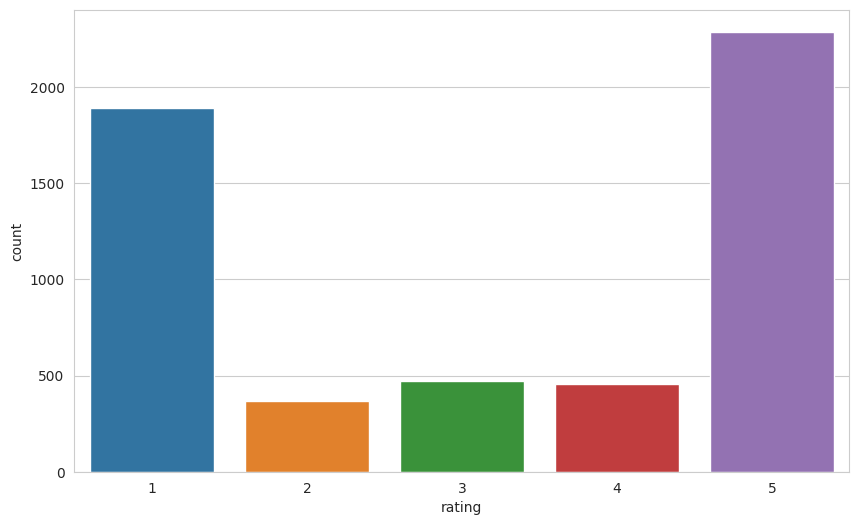

In [11]:
sns.countplot(data = df, x = 'rating')     #plot for rating against count

**FE (Feature Engineering):**

In [12]:
#now comes the main NLP part
#we will remove symbols, emojis and other unique characters from the dataset
#this is a crucial part of NLP

import re
import emoji

def cleantext(text):
    if isinstance(text, str):  #check if text is a string
        # Remove emojis
        text = emoji.demojize(text)
        text = re.sub(r'\s+$', '', text)  #remove trailing whitespace
        # Removing mentions
        text = re.sub(r"@[0-9a-zA-Z]+", "", text)   #removing @ and keeping numbers & texts
        # Removing '#' from reviews
        text = re.sub(r"#", "", text)      #removing #
        # Removing Retweets
        text = re.sub(r"RT[\s]+", "", text)    
        # Removing hyperlinks
        text = re.sub(r"https?:\\/\\/S+", "", text)       #cleaning links
        # Remove extra whitespace 
        text = re.sub(r"\s+", " ", text).strip()
    return text

In [13]:
#applying the cleaning function that we created 

df['review'] = df['review'].fillna('').apply(cleantext)

In [14]:
df.head()       #it is looking clean and ready now

,rating,review
0,5,nice
1,5,"best biryani , so supportive staff of outlet ,..."
2,4,delivery boy was very decent and supportive.:O...
3,1,"worst biryani i have tasted in my life, half o..."
4,5,all food is good and tasty . will order again ...


In [15]:
#lets create two new features 
#1) Subjectivity & 2) Polarity
#for sentiments

def calculate_sentiments(ds):
    sentiments = TextBlob(ds['review']).sentiment
    return pd.Series([sentiments.subjectivity, sentiments.polarity])

In [16]:
#implementing

df[['subjectivity', 'polarity']] = df.apply(calculate_sentiments, axis = 1)
df.head()

,rating,review,subjectivity,polarity
0,5,nice,1.000,0.600
1,5,"best biryani , so supportive staff of outlet ,...",0.617,0.617
2,4,delivery boy was very decent and supportive.:O...,0.867,0.217
3,1,"worst biryani i have tasted in my life, half o...",0.583,-0.583
4,5,all food is good and tasty . will order again ...,0.550,0.600


In [17]:
#inbuilt stopwords for english from nltk module 

stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
#removing stopwords from the text

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))  # Load stopwords only once
  filtered_words = [word for word in text.split() if word not in stop_words]
  return ' '.join(filtered_words)

In [19]:
df['review']=df['review'].apply(remove_stopwords)    #applying

In [20]:
#url link to visualize our wordcloud in better and attractive way

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Instagram_icon.png/768px-Instagram_icon.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
mask = np.array(img)

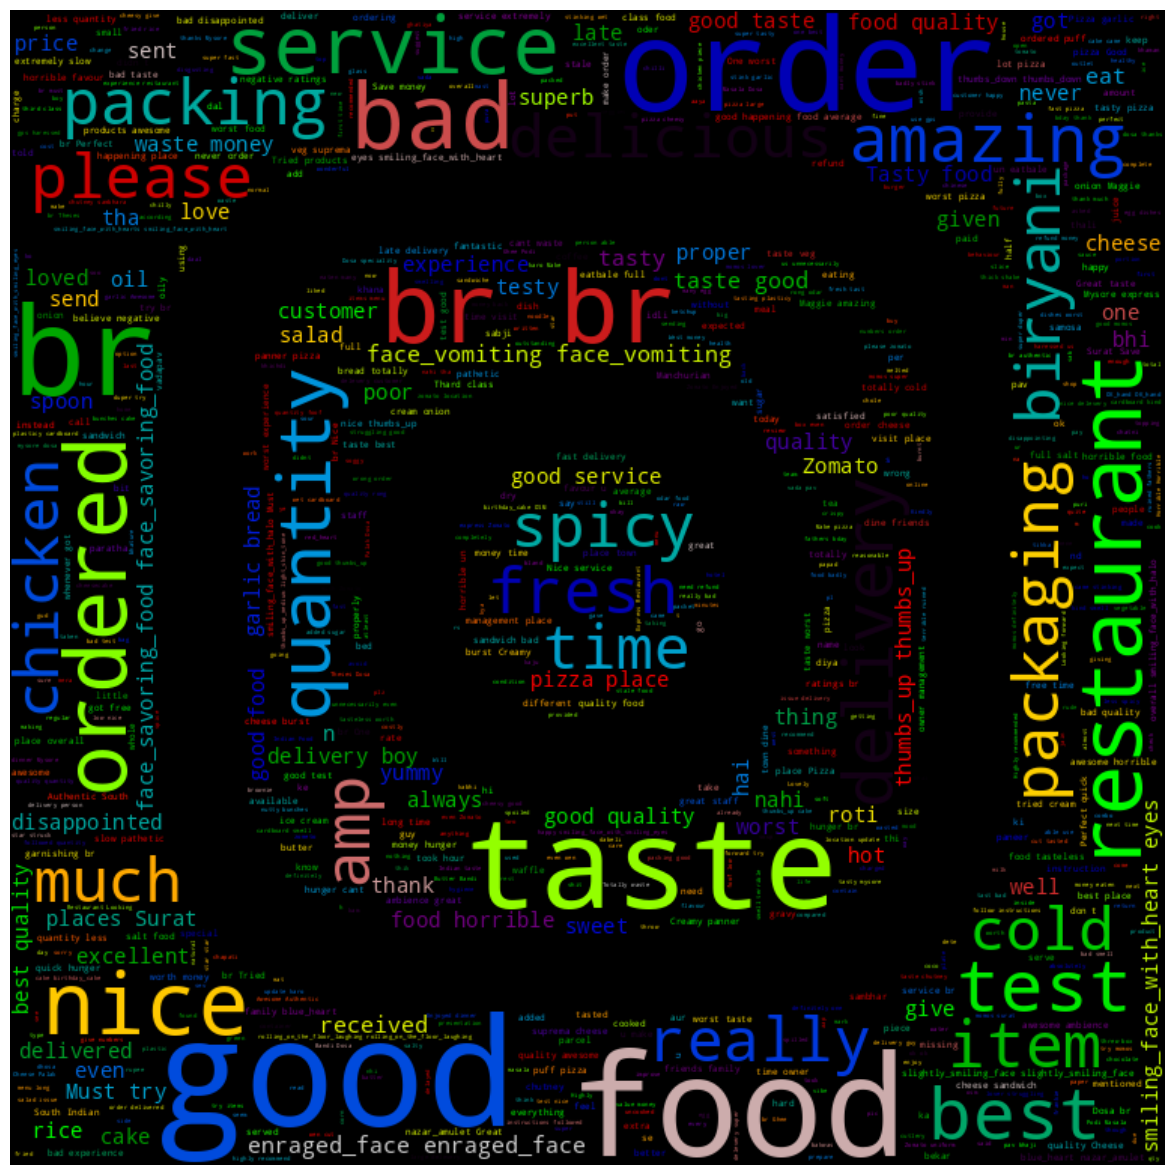

In [21]:
#look how beautiful it looks and can be understoood so well
#lets try in diffferent ways...


plt.figure(figsize=(15,15))
all_words = " ".join(words for words in df['review'])
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black',\
                      max_words=800,colormap="nipy_spectral", mask = mask).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

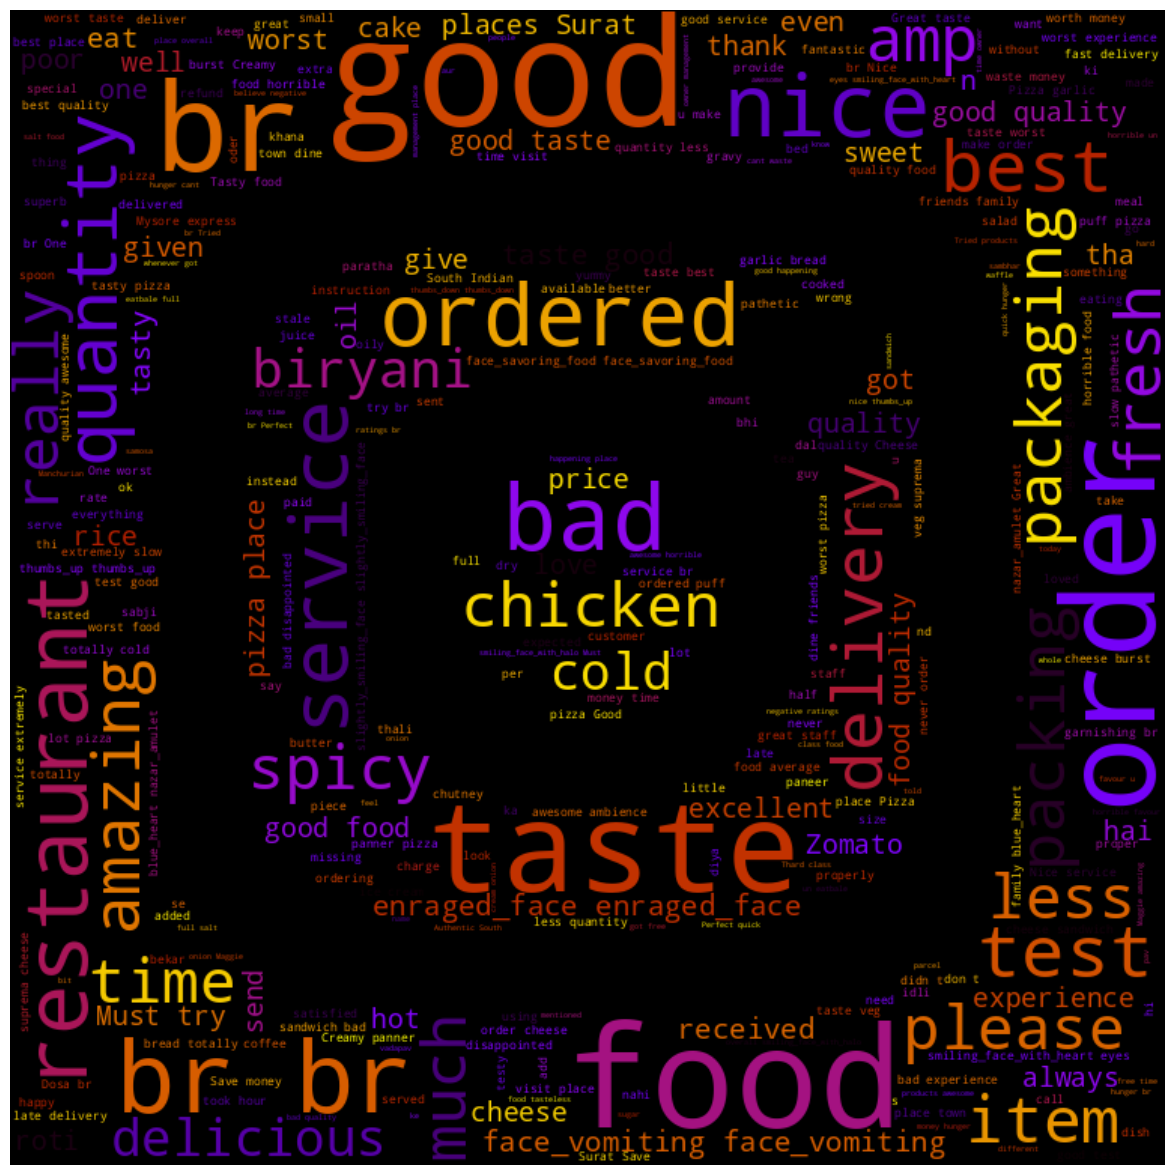

In [22]:
plt.figure(figsize=(15,15))
all_words = " ".join(words for words in df['review'])
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', \
                      max_words=800,colormap="gnuplot", mask = mask).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

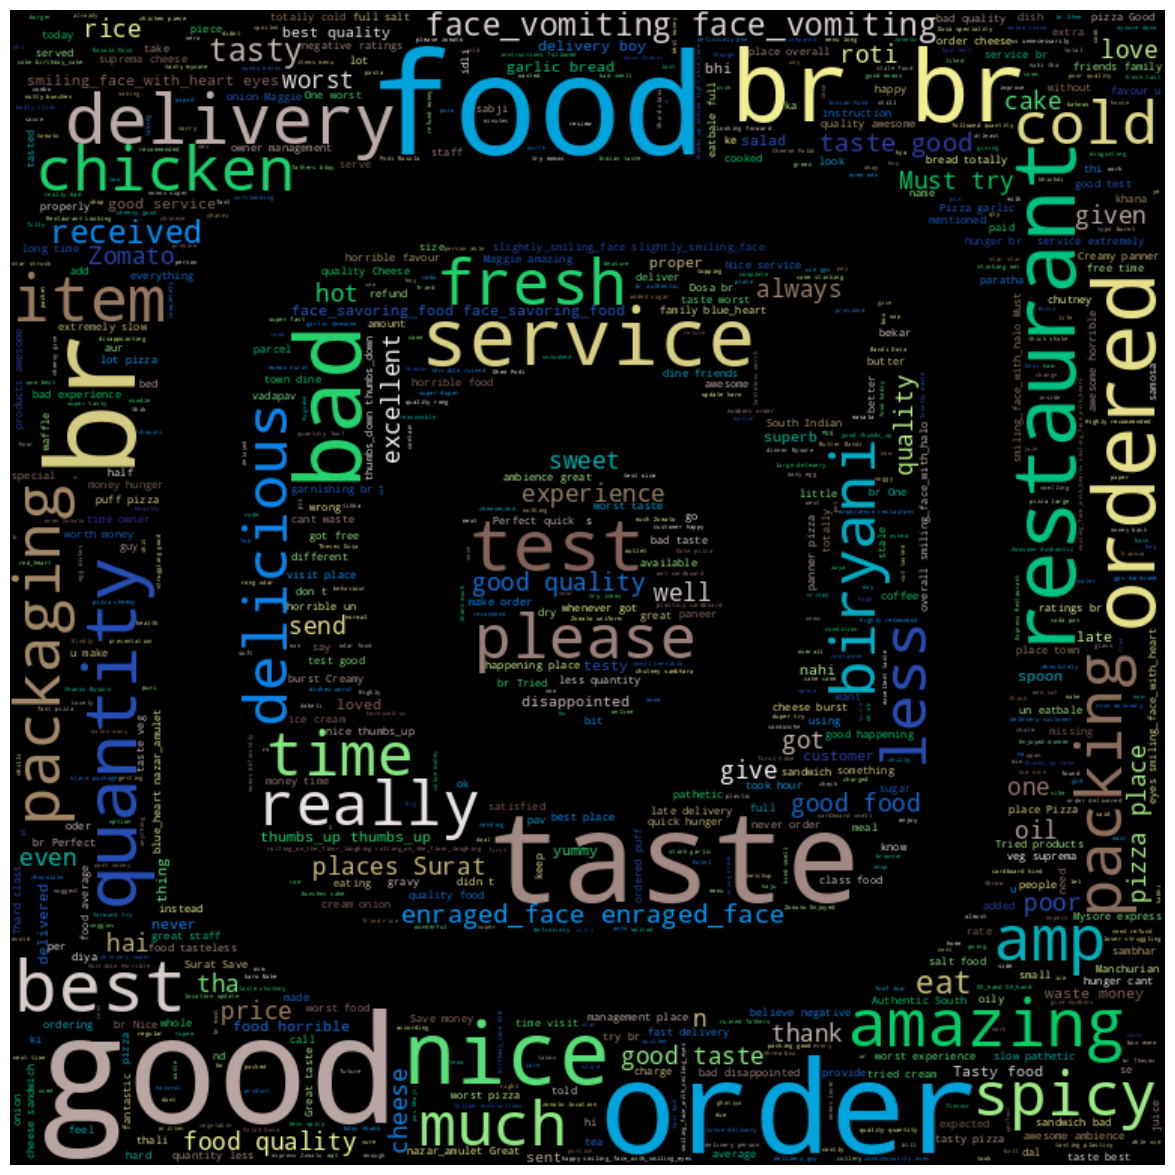

In [23]:
plt.figure(figsize=(15,15))
all_words = " ".join(words for words in df['review'])
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', \
                      max_words=800,colormap="terrain", mask = mask).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
#creating new feature again fro sentiment analysis
#dividing it in to three -ve, +ve and neutral

def categorize_sentiment(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

In [25]:
#creating new feature for the same 

df['sentiment_analysis'] = df['polarity'].apply(categorize_sentiment)
df.head()

,rating,review,subjectivity,polarity,sentiment_analysis
0,5,nice,1.000,0.600,Positive
1,5,"best biryani , supportive staff outlet , perso...",0.617,0.617,Positive
2,4,delivery boy decent supportive.:OK_hand::thumb...,0.867,0.217,Positive
3,1,"worst biryani tasted life, half biryani dustbin.",0.583,-0.583,Negative
4,5,food good tasty . order lots explore bawarchi'...,0.550,0.600,Positive


<Axes: xlabel='polarity', ylabel='Density'>

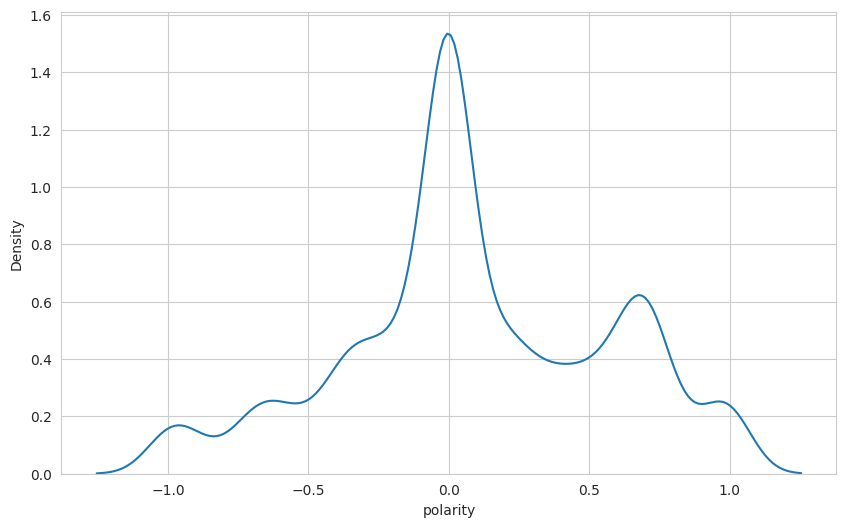

In [26]:
sns.kdeplot(data = df, x = "polarity")   #kde plot

<Axes: xlabel='polarity', ylabel='Count'>

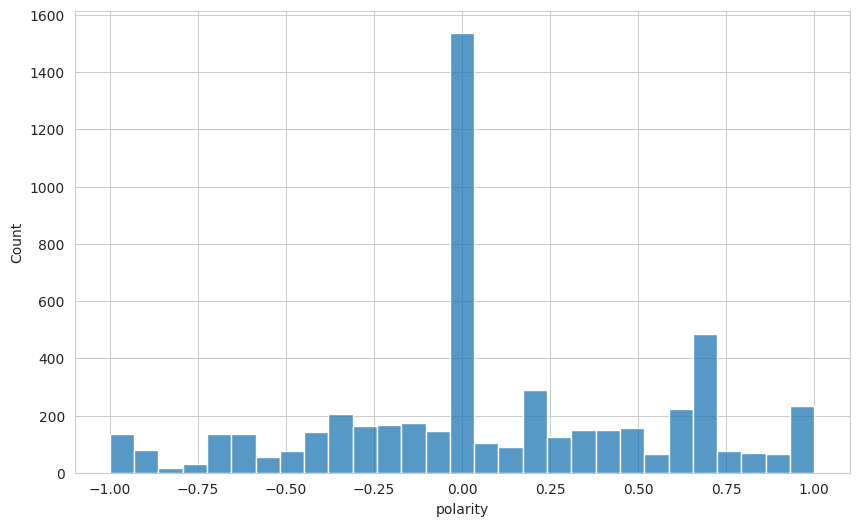

In [27]:
sns.histplot(data = df, x = 'polarity')    #hist plot

<Axes: xlabel='sentiment_analysis', ylabel='count'>

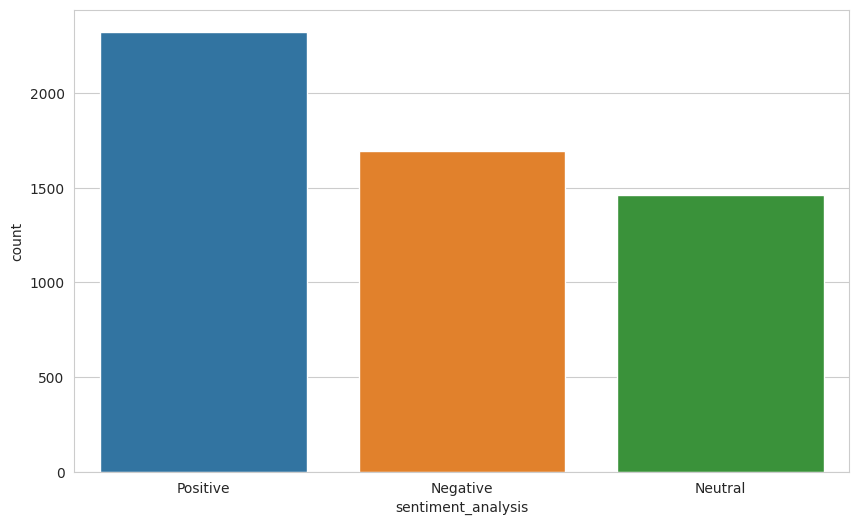

In [28]:
sns.countplot(data = df, x = 'sentiment_analysis')     #count plot

In [29]:
#creating new dataframe from existing one 

new_df = df
new_df.rename(columns= {'review_description' : 'text'}, inplace = True)
new_df = new_df[['review', 'sentiment_analysis']]
new_df

,review,sentiment_analysis
0,nice,Positive
1,"best biryani , supportive staff outlet , perso...",Positive
2,delivery boy decent supportive.:OK_hand::thumb...,Positive
3,"worst biryani tasted life, half biryani dustbin.",Negative
4,food good tasty . order lots explore bawarchi'...,Positive
...,...,...
5474,complain,Neutral
5475,took 1 hour assign valvet thn prepare food lik...,Negative
5476,"took hour prepare 3 khawsa, real life gets pre...",Positive
5477,"late, littrally time pass items proper",Negative


In [30]:
#encoding for sentiment analysis 
#we can also do mapppinng as we only have 3 variables

encoder = LabelEncoder()
new_df['sentiment_analysis'] = encoder.fit_transform(new_df['sentiment_analysis'])

In [31]:
new_df.head()

,review,sentiment_analysis
0,nice,2
1,"best biryani , supportive staff outlet , perso...",2
2,delivery boy decent supportive.:OK_hand::thumb...,2
3,"worst biryani tasted life, half biryani dustbin.",0
4,food good tasty . order lots explore bawarchi'...,2


In [32]:
#creating pipline

pipeline = Pipeline([
    ('Vectorizing', CountVectorizer()),
    ('TFID', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

**FS (Feature Selection):**

In [33]:
#splitting data in 4

X = new_df['review']
y = new_df['sentiment_analysis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [34]:
#splitting data into 2

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
#fitting into pipline

pipeline.fit(X_train, y_train)

Pipeline(steps=[('Vectorizing', CountVectorizer()),
                ('TFID', TfidfTransformer()), ('classifier', MultinomialNB())])

In [36]:
#prediction

pred = pipeline.predict(X_test)

In [37]:
#confusion matrix

confusion_matrix(y_test, pred)

array([[268,   8,  50],
       [ 44, 146,  89],
       [ 34,  16, 441]])

In [38]:
#classification report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       326
           1       0.86      0.52      0.65       279
           2       0.76      0.90      0.82       491

    accuracy                           0.78      1096
   macro avg       0.80      0.75      0.76      1096
weighted avg       0.79      0.78      0.77      1096



**Model Development, Deployment and Model Selction**


In [39]:
#try using different models like RoBERTa
#that makes sence
#with hyper parameters 
"""
model_type="bert"
model_name= "bert-base-cased"
if model_type == "bert":
    model_name = "bert-base-cased"

elif model_type == "roberta":
    model_name = "roberta-base"

elif model_type == "distilbert":
    model_name = "distilbert-base-cased"

elif model_type == "distilroberta":
    model_type = "roberta"
    model_name = "distilroberta-base"

elif model_type == "electra-base":
    model_type = "electra"
    model_name = "google/electra-base-discriminator"

elif model_type == "electra-small":
    model_type = "electra"
    model_name = "google/electra-small-discriminator"

elif model_type == "xlnet":
    model_name = "xlnet-base-cased"


model_args = QuestionAnsweringArgs()
model_args.train_batch_size = 16
model_args.evaluate_during_training = True
model_args.n_best_size=3
model_args.num_train_epochs=5



train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,
    "output_dir": f"outputs/{model_type}",
    "best_model_dir": f"outputs/{model_type}/best_model",
    "evaluate_during_training": True,
    "max_seq_length": 128,
    "num_train_epochs": 5,
    "evaluate_during_training_steps": 1000,
    "wandb_project": "Question Answer Application",
    "wandb_kwargs": {"name": model_name},
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "n_best_size": 3,
    #"use_early_stopping": True,
    #"early_stopping_metric": "mcc",
    #"n_gpu": 2,
    #"manual_seed": 4,
    #"use_multiprocessing": False,
    "train_batch_size": 128,
    "eval_batch_size": 64,
    #"config": {
    #"output_hidden_states": True
    # }
}


model = QuestionAnsweringModel(
    model_type,model_name, args=train_args
)
"""

'\nmodel_type="bert"\nmodel_name= "bert-base-cased"\nif model_type == "bert":\n    model_name = "bert-base-cased"\n\nelif model_type == "roberta":\n    model_name = "roberta-base"\n\nelif model_type == "distilbert":\n    model_name = "distilbert-base-cased"\n\nelif model_type == "distilroberta":\n    model_type = "roberta"\n    model_name = "distilroberta-base"\n\nelif model_type == "electra-base":\n    model_type = "electra"\n    model_name = "google/electra-base-discriminator"\n\nelif model_type == "electra-small":\n    model_type = "electra"\n    model_name = "google/electra-small-discriminator"\n\nelif model_type == "xlnet":\n    model_name = "xlnet-base-cased"\n\n\nmodel_args = QuestionAnsweringArgs()\nmodel_args.train_batch_size = 16\nmodel_args.evaluate_during_training = True\nmodel_args.n_best_size=3\nmodel_args.num_train_epochs=5\n\n\n\ntrain_args = {\n    "reprocess_input_data": True,\n    "overwrite_output_dir": True,\n    "use_cached_eval_features": True,\n    "output_dir":

In [40]:
#BERT model initialization

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
#convert the text data to input features


input_ids = []
attention_masks = []

for review in new_df['review']:
    encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt'
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(new_df['sentiment_analysis'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [42]:
#splitting again...

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.2)

In [43]:
#sampling data that was splitted

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [44]:
def flat_accuracy(logits, labels):
    # Calculate accuracy
    predictions = np.argmax(logits, axis=1)
    correct = np.sum(predictions == labels)
    accuracy = correct / len(labels)
    return accuracy

In [45]:
#model is here

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 5 

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        optimizer.zero_grad()
        
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)
    
    print(f'Epoch {epoch+1}:')
    print(f'Training loss: {avg_train_loss}')
    print(f'Validation loss: {avg_val_loss}')
    print(f'Validation accuracy: {avg_val_accuracy}')

Epoch 1:
Training loss: 0.8970909899603712
Validation loss: 0.6044171793120248
Validation accuracy: 0.7526785714285714
Epoch 2:
Training loss: 0.5467559455955115
Validation loss: 0.5516659012862615
Validation accuracy: 0.7839285714285714
Epoch 3:
Training loss: 0.43118761354771845
Validation loss: 0.5152238130569458
Validation accuracy: 0.8
Epoch 4:
Training loss: 0.3336306947426204
Validation loss: 0.5512348115444183
Validation accuracy: 0.8071428571428572
Epoch 5:
Training loss: 0.25699609507174387
Validation loss: 0.6393220675843102
Validation accuracy: 0.7973214285714286


We can definately do better than this. Using other models and using hyperparamters will help a lot. I have only used one algorithm in the pipeline we can use more than that. That will let us know which model is performing better. Here, Multinominal NB is performing good but we can try more.